In [1]:
import torch
import torch.backends.cudnn as cudnn
device = torch.cuda.set_device('cuda:0')
import matplotlib.pyplot as plt
from skimage.io import imread 
from skimage.transform import resize
import numpy as np
from utils import *
from skimage.io import imread
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose
import cv2

In [2]:
import archs

In [3]:
model = archs.NestedUNet(1, 1, False)

In [4]:
model = model.cuda()

In [5]:
#Load save model
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [6]:
model.eval()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    

In [7]:
network_size = (256,256,1)

In [8]:
overlap = 64

In [9]:
image2 = imread('200414_fbnc_74_pan_clo_R1C1.tif')
image_size2 = list(image2.shape[0:2]) #Get image size and push to a list
tile_size = list(network_size[0:2]) #Get tile size as first two dimensions of network_size
        
corners = find_corners(image_size2, tile_size, network_size, overlap)


img2 = image2
mean_ch = (446 / 2**11) * 2**8
std_ch = (165 / 2**11) * 2**8
img2 = (img2 - mean_ch) / (std_ch)
img2 = img2.reshape(img2.shape + (1,))

tilesArr2 = create_tiles(img2, corners, network_size)
tilesArr2 = tilesArr2.astype('float32')
tilesArr2 = tilesArr2.transpose(0, 3, 1, 2)
tilesArr2 = torch.from_numpy(tilesArr2)
tilesArr2 = tilesArr2.cuda()


In [10]:
with torch.no_grad():
    output = model(tilesArr2)
    #output = model(img2)
    output = torch.sigmoid(output).cpu().numpy()

In [11]:
torch.cuda.empty_cache()

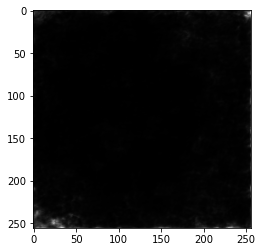

In [12]:
plt.imshow(output[0,0,:,:], cmap='gray')

In [13]:
final = assemble_pred(output, corners, image2, network_size)

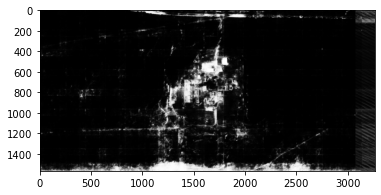

In [14]:
plt.imshow(final, cmap="gray")

In [15]:
final2 = np.array(final*255, dtype="uint16")

In [16]:
import cv2
ret2,th2 = cv2.threshold(final2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

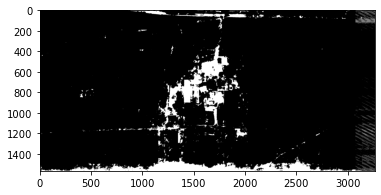

In [17]:
plt.imshow(th2, cmap = 'gray')

In [18]:
plt.imshow(img[:,:,0], cmap="gray")

NameError: name 'img' is not defined

In [20]:
from skimage.io import imsave
imsave("test.png", final2)

<ipython-input-20-20c8f5feb502>:2: UserWarning: test.png is a low contrast image
  imsave("test.png", final2)
